https://analyzecore.com/2015/08/27/measuring-business-health-with-delta-lifecycle-grids-and-r/

We will study how to use LifeCycle Grids concept for measuring a health of the business in this post.

Obviously, that business depends on customers purchasing behavior. Purchase frequency leads to higher customer lifetime value to date and purchase recency leads to higher potential lifetime value. And they both lead to higher total customer lifetime value. Therefore, the more frequent and recent purchases that customers do the healthier business.

Previously we’ve touched a topic of comparing cohorts and their progress through the customer’s lifecycle prism. But what if we want to measure the health of business on the high level.

Once we discovered how our clients are distributed through Lifecycle Grids, we can use pretty simple and effective technic called Delta Analysis and create Delta LifeCycle Grids. Delta means the difference. 

The main idea is the following: 
* We can create two consecutive LifeCycle Grids as of two reporting dates and calculate the difference between the corresponding cells. 
* The delta values (differences) would tell us where we have positive and negative changes and is it good for us or not. Let’s study this idea with a practical example.

As usually, we will use powerful tool R language that will allow us to create the example with more than two consecutive LifeCycle Grids and visualize the result effectively.

Ok, let’s assume that we have a dataset that looks like:

In [2]:
clientId orderdate
1    762   2012-05-10
2    461   2012-05-16
3    641   2012-07-07
4   1040   2013-02-22
5    128   2013-01-15
6    339   2013-03-13


ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: clientId orderdate
             ^


Actually, this dataset is enough for doing LifeCycle Grids analysis. We would calculate a number of orders from each customer (frequency) and time lapse from the last purchase (recency). You can reproduce this dataset with the following code:

In [12]:
# loading libraries
library(dplyr)
library(reshape2)
library(ggplot2)
library(lubridate)
 
set.seed(10)
# creating orders data sample
orders <- data.frame(
    clientId = sample(c(1:1500), 5000, replace = TRUE),
    orderdate = sample((1:500), 5000, replace = TRUE))

orders$orderdate <- as.Date(orders$orderdate, origin = "2012-01-01")
head(orders)

,clientId,orderdate
1,762,15470
2,461,15476
3,641,15528
4,1040,15758
5,128,15720
6,339,15777


We will do Delta Analysis based on historical data for the last six months on the monthly basis and find out is there positive or negative trend for our business’s health. 

In this case, we need to specify seven reporting dates because we will analyze six delta values. Let’s assume that they are from 2012-11-01 until 2013-05-01. 

Further, we need to create LifeCycle Grids for each date and calculate differences between them consequently. We will use the following code:

In [13]:
# specifying reporting dates for monthly analysis
rep.dates <- seq(as.Date('2012-11-01', format = '%Y-%m-%d'),
as.Date('2013-05-01', format = '%Y-%m-%d'), "month")
 
# creating empty data frames
lcg.cache <- data.frame()
lcg <- data.frame()
 
# creating LCG for each reporting date
for (i in c(1:length(rep.dates))) {
  
    customers <- orders %>%
    filter(orderdate < rep.dates[i]) %>%
    group_by(clientId) %>%
    summarise(frequency = n(),
    recency = as.numeric(rep.dates[i] - max(orderdate))) %>%
    # adding segments
    mutate(segm.freq = ifelse(between(frequency, 1, 1), '1',
    ifelse(between(frequency, 2, 2), '2',
    ifelse(between(frequency, 3, 3), '3',
    ifelse(between(frequency, 4, 5), '4-5', '>5'))))) %>%
    mutate(segm.rec = ifelse(between(recency, 0, 30), '0-30 days',
    ifelse(between(recency, 31, 90), '31-90 days',
    ifelse(between(recency, 91, 180), '91-180 days', '>180 days')))) %>%
    ungroup()

    # defining order of boundaries
    customers$segm.freq <- factor(customers$segm.freq, levels = c('>5', '4-5', '3', '2', '1'))
    customers$segm.rec <- factor(customers$segm.rec, levels = c('>180 days', '91-180 days', '31-90 days', '0-30 days'))

    # creating LCG as of reporting date
    lcg.cache <- customers %>%
    group_by(segm.freq, segm.rec) %>%
    summarise(quantity = n()) %>%
    ungroup() %>%
    mutate(repdate = format(rep.dates[i], format = '%Y-%m'))

    # binding all LCGs
    lcg <- rbind(lcg, lcg.cache)
}
 
# calculating Delta LCG
delta.lcg <- lcg %>%
group_by(segm.freq, segm.rec) %>%
arrange(repdate) %>%
mutate(prev = lag(quantity),
delta = quantity - prev) %>%
# removing base reporting period
na.omit() %>%
ungroup()

In [14]:
head(lcg)

,segm.freq,segm.rec,quantity,repdate
1,>5,91-180 days,3,2012-11
2,>5,31-90 days,8,2012-11
3,>5,0-30 days,20,2012-11
4,4-5,>180 days,3,2012-11
5,4-5,91-180 days,45,2012-11
6,4-5,31-90 days,78,2012-11


And the final step before analyzing is visualization. There are two examples that I want to share with you:

* The first one shows deltas/differences only. 
* The second one includes both differences and total numbers. You can reproduce these plots with the following code:

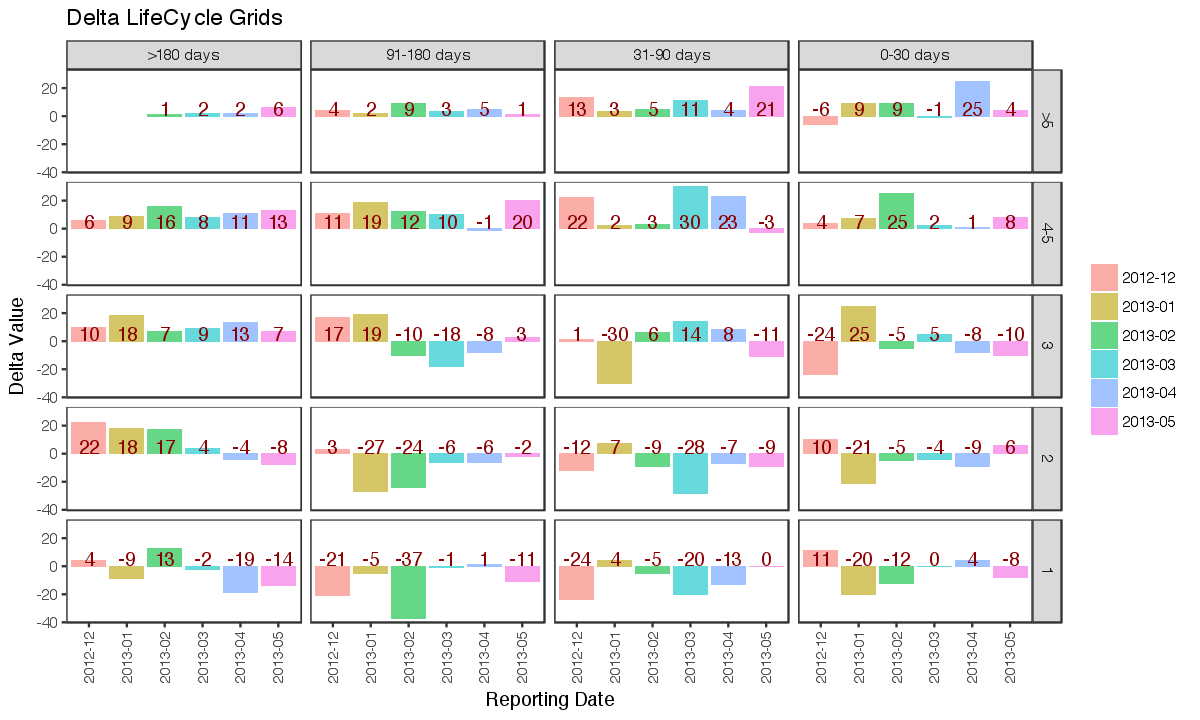

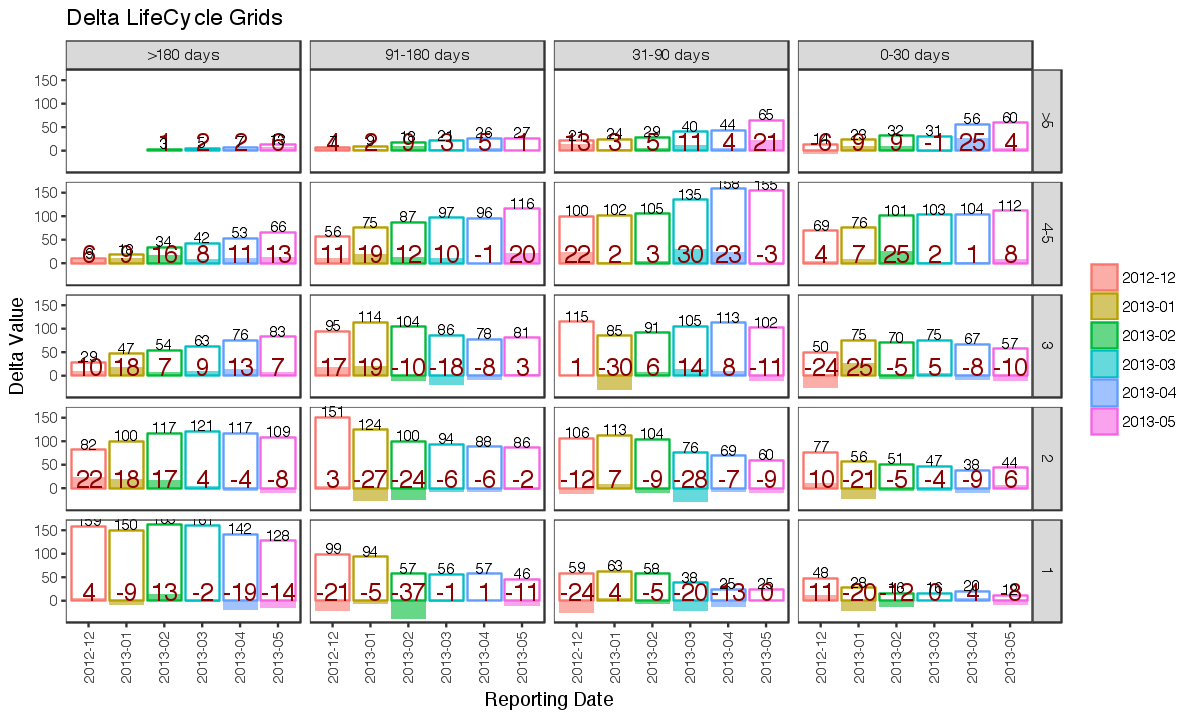

In [25]:
library(repr)
options(repr.plot.width=10, repr.plot.height=6)

# plotting results
ggplot(delta.lcg, aes(x = repdate, y = delta, fill = repdate)) +
theme_bw() +
theme(panel.grid = element_blank(),
axis.text.x = element_text(size = 8, angle = 90, hjust = 0.5, vjust = 0.5, face = "plain"),
legend.title = element_blank()) +
geom_bar(stat = 'identity', alpha = 0.6) +
geom_text(aes(y = 0, label = delta), color = 'darkred', vjust = 0, size = 4, fontface = "bold") +
facet_grid(segm.freq ~ segm.rec) +
xlab("Reporting Date") +
ylab("Delta Value") +
ggtitle("Delta LifeCycle Grids")
 
ggplot(delta.lcg, aes(x = repdate, y = delta, fill = repdate)) +
theme_bw() +
theme(panel.grid = element_blank(),
axis.text.x = element_text(size = 8, angle = 90, hjust = 0.5, vjust = 0.5, face = "plain"),
legend.title = element_blank()) +
geom_bar(stat = 'identity', alpha = 0.6) +
geom_bar(aes(y = quantity, color=repdate), stat = 'identity', alpha=0) +
geom_text(aes(y = 0, label = delta), color = 'darkred', vjust = 0, size = 5, fontface = "bold") +
geom_text(aes(y = quantity, label = quantity), vjust = 0, size = 3) +
facet_grid(segm.freq ~ segm.rec) +
xlab("Reporting Date") +
ylab("Delta Value") +
ggtitle("Delta LifeCycle Grids")

You can see both positive and negative numbers in the Delta LifeCycle Grids and dynamics of deltas, depending on whether the number of customers in the cell grew or got smaller. 

The healthier business the more positive deltas you should see on the right part of the chart (‘0-30 days’ and ’31-90 days’ columns) and more negative deltas on the left part (’91-180 days’ and ‘>180 days’ columns). 

In other words, this means the number of customers grow in ‘alive’ cells and get smaller in ‘dead’ cells.

Let’s take a look on our example. It would be helpful to start with the last month (2013-05) analysis and then take a look on trends.

We can create a separate matrix with numbers and totals with the following code:

In [26]:
# last month&nbsp;delta matrix
delta.lcg.m <- delta.lcg %>% filter(repdate == '2013-05')
 
delta.lcg.m <- dcast(delta.lcg.m, segm.freq ~ segm.rec, value.var = 'delta')
 
row.names(delta.lcg.m) <- delta.lcg.m$segm.freq
delta.lcg.m <- delta.lcg.m[, -1]
 
delta.lcg.m$total <- rowSums(delta.lcg.m)
delta.lcg.m['total', ] <- colSums(delta.lcg.m)

In [27]:
delta.lcg.m

,>180 days,91-180 days,31-90 days,0-30 days,total
>5,6,1,21,4,32
4-5,13,20,-3,8,38
3,7,3,-11,-10,-11
2,-8,-2,-9,6,-13
1,-14,-11,0,-8,-33
total,4,11,-2,0,13


Let’s start with columns and rows totals. 

* You can see that we have the positive values on the left side of the matrix (4 and 11) and the negative ones on the right (-2 and 0). 
  * This means our customers have moved from ‘alive’ cells to ‘dead’ and it would be expensive to reactivate them. 
  
* Regarding rows, we have negative values on the bottom and positive ones on the top. 
  * This means that customers have moved from one-time buyers to more frequent and it is good, but we can see the negative delta (-8) in the cell ‘0-30 days – 1 purchase’ where brand new customers are placed. 
  * This loss might be amplified by a lack of new customers to replace those moving out of the cell. 
  
A short summary is the following: 

**Although we have positive changes in purchases frequency, valuable customers tend to leave us.**

Additionally, we need to check the number of new clients.

If we take a look on the trends we would find almost the same situation as we have with the last month. And this situation is not good. We tend to lose good and best customers (the growth in cells ‘>180 days – from 3 to >5 purchases’).

It seems like our retention politics doesn’t work effectively with customers who have become frequent buyers. And we need to pay attention to the number of brand new customers.

Let’s make a conclusion. 

**Delta LifeCycle Grids approach allows us to represent changes in consecutive LifeCycle Grids and identify customer flows and trends.**

We need take into account that there could be quite a lot of reasons for changes. For instance, customers could change their behavior because of changes in product/service, seasonality or promo activities, etc. Don’t forget about and take these reasons into account.